In [1]:
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fftpack
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import glob
import os
from sklearn.metrics import r2_score
from pynufft import NUFFT_cpu

import sys
sys.path.append("../")
from mfilter.regressions import * #here it is the regression
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples
from mfilter.transform.transform import FourierTransform, FFT, Regression
from mfilter.filter.mfilter import mfilter

In [36]:
# frequency grid
def f_grid(t, gamma=1, f_max=None, f_min=None):
    if f_max is None:
        f_max = 0.5 * t.average_fs
    if f_min is None:
        f_min = 1/t.duration
    df = f_min / gamma
    return FrequencySamples(input_time=t, minimum_frequency=f_min, maximum_frequency=f_max,
                            samples_per_peak=gamma)

def micro_lens(U0, t0, tE, fs, times):
    """Evaluate microlens event at given time array, return magnitude difference"""
    u = np.sqrt(U0**2 + ((times - t0)  /tE )**2)
    A = (u**2 + 2.) / (u * np.sqrt(u**2 + 3))
    dm = - 2.5 * np.log10(fs*(A - 1) + 1)
    return dm
    
def scores(y_trues, y_predicts):
    r2 = []
    for y_true, y_pred in zip(y_trues, y_predicts):
        r2.append(r2_score(y_true, y_pred))
        
    return r2

def plot_freqs(orig_data, orig_time, times, fts, freqs, recon_datas, labels=["FFT", "SGD"], 
               titles=["FT real", "FT imag.", "FT abs.", "Data"], 
               xaxis=["x", "x", "x", "x"], main_title="A title"):
    fsize=14
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(12, 7))
    fig.suptitle(main_title, fontsize=fsize)
    ax4.plot(orig_time, orig_data, "k.", label="Original Data.")
    for t, ft, f, d, lb in zip(times, fts, freqs, recon_datas, labels):
        ax1.semilogx(f, np.real(ft), label="FT-{}".format(lb))
        ax2.semilogx(f, np.imag(ft), label="FT-{}".format(lb))
        ax3.semilogx(f, np.abs(ft), label="FT-{}".format(lb))
        ax4.plot(t, d, label="data-from-{}".format(lb))
        
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fsize)
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fsize)
    for x, ttl, ax in zip(xaxis, titles, [ax1, ax2, ax3, ax4]):
        ax.set_xlabel(x, fontsize=fsize)
        ax.set_title(ttl, fontsize=fsize)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    fig.subplots_adjust(top=0.88)
    
    
# read file
def read_file():
     # folder MLensing with the files should be placed out 
     # of the root file of the project (the one with the .git)
    return glob.glob("../../MLensing/*.mjd")

def read_data(files, j, ini, end, normalize_time=False):
    a = pd.read_csv(files[j], skiprows=3, header=None, sep=" ") # read the table
    a.columns = ["MJD", "Mag", "err"] # name the columns
    times = TimesSamples(a["MJD"][ini:end]) # read the times in MJD
    times -= times.min() # normalize to 0, this give us units of days
    times *= days_to_sec # transform to units of seconds
    if normalize_time:
        print("before normalize, we get an average sampling rate of:", 
              times.average_fs, "samples per seconds")
        times *= times.average_fs # normalize to units of samples (for digital signals)
        print("after normalize, we get an average sampling rate of:", times.average_fs, 
              "samples per cycles \n with this, perfect reconstruction is guaranteed " +
              "possible for a bandlimit of: ", times.average_fs/2)
        
    data = TimeSeries(a["Mag"][ini:end], times=times) # get the magnitude
    data -= np.median(data) # normalize the magnitud to 0 (the center goes to 0).
    err =  a["err"].tolist()[ini:end] # get the error
    return times, data, err



# define constants
reg = SGDRegression(alpha=10**(-4), max_iter=500, penalty="l2", l1_ratio=0.5, tol=0.001)
N = 200
j = 10 # the particular observation to use, j={5, 9, 14} gives bad results 
ini = 0 # init of a range of the observations, we use the whole data
end = -1 # end of a range of the observation, we use the whole data
days_to_sec = 1 * 24 * 60 * 60 # transformation from days to seconds
sec_to_days = 1 /(60 * 60 * 24) # transformation from seconds to days


teoretical match should give a time of match (offset) of:  1721.420442053267


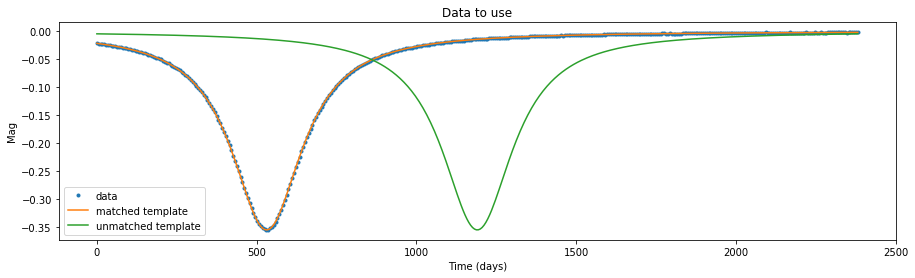

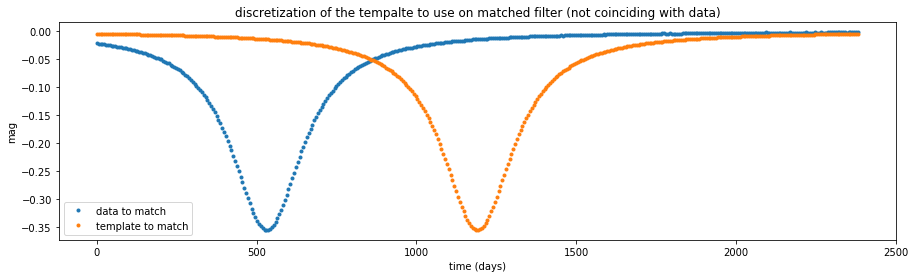

In [37]:
files = read_file()
times, data, err = read_data(files, j, ini, end, normalize_time=False)
times *= sec_to_days
times = TimesSamples(np.linspace(times.min(), times.max(), len(times)))

te = 30
fs = 13.2 
u0 = 4.2
L = 93
data = TimeSeries(micro_lens(u0, times[L]-5, te, fs, times) + np.random.normal(0, 0.0002, len(times)), times=times)
uniform_time = TimesSamples(np.linspace(times.min(), times.max(), 2*N))
temp_matched = TimeSeries(micro_lens(u0, times[L]-5, te, fs, uniform_time), times=uniform_time)

def temp(t0, times):
    return TimeSeries(micro_lens(u0, t0, te, fs, times), times=times)

unmatched_template = temp(times.duration/2, uniform_time)

plt.figure(figsize=(15, 4))
plt.plot(times, data, '.', label="data")
plt.plot(uniform_time, temp_matched, label="matched template")
plt.plot(uniform_time, unmatched_template, label="unmatched template")
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Mag")
plt.title("Data to use")

template = temp(times.duration/2, times)
plt.figure(figsize=(15, 4))
plt.plot(times, data, '.', label='data to match')
plt.plot(times, template, '.', label='template to match')
plt.legend()
plt.title("discretization of the tempalte to use on matched filter (not coinciding with data)")
plt.xlabel("time (days)")
plt.ylabel('mag')

teoretical_time = max(times) + times[L]-5 - times.duration/2
print("teoretical match should give a time of match (offset) of: ", teoretical_time)

In [44]:
a = np.fft.fftfreq(len(times)+1)
np.roll(a, (len(times)+1)//2)

array([-0.49879518, -0.49638554, -0.4939759 , -0.49156627, -0.48915663,
       -0.48674699, -0.48433735, -0.48192771, -0.47951807, -0.47710843,
       -0.4746988 , -0.47228916, -0.46987952, -0.46746988, -0.46506024,
       -0.4626506 , -0.46024096, -0.45783133, -0.45542169, -0.45301205,
       -0.45060241, -0.44819277, -0.44578313, -0.44337349, -0.44096386,
       -0.43855422, -0.43614458, -0.43373494, -0.4313253 , -0.42891566,
       -0.42650602, -0.42409639, -0.42168675, -0.41927711, -0.41686747,
       -0.41445783, -0.41204819, -0.40963855, -0.40722892, -0.40481928,
       -0.40240964, -0.4       , -0.39759036, -0.39518072, -0.39277108,
       -0.39036145, -0.38795181, -0.38554217, -0.38313253, -0.38072289,
       -0.37831325, -0.37590361, -0.37349398, -0.37108434, -0.3686747 ,
       -0.36626506, -0.36385542, -0.36144578, -0.35903614, -0.35662651,
       -0.35421687, -0.35180723, -0.34939759, -0.34698795, -0.34457831,
       -0.34216867, -0.33975904, -0.3373494 , -0.33493976, -0.33

0.08653014385261742 0.08653014385261742


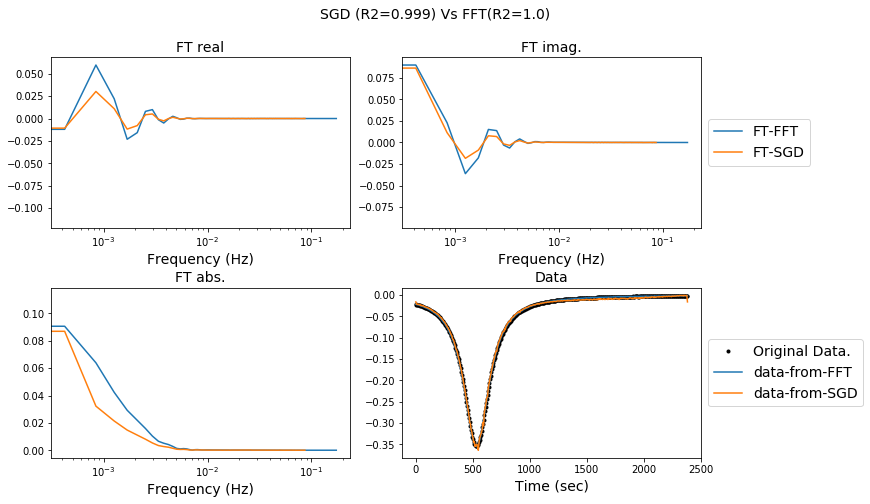

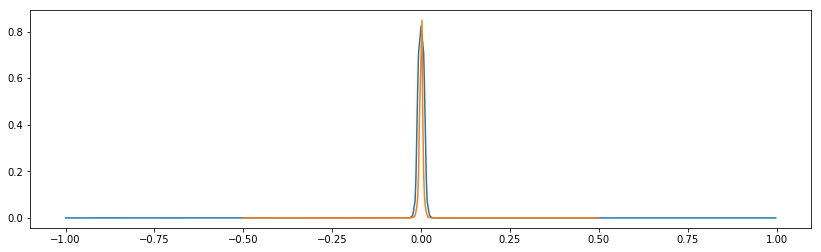

In [59]:
# define transformers for fft and sgd
N = len(times)
fs = times.average_fs
fft = FFT(times, beta=2) # FFT transformer, beta is a factor on the number of interpolated points (beta * N)
eve_freqs = np.fft.fftfreq(N) * fs # fft freq without 0 on real part (positive freqs)
freqs = FrequencySamples(np.sort(eve_freqs[1:-1])) # we exclude the 0 freq
sgd = Regression(reg=reg,freq=freqs)  # it use a regressor and a frequency grid defined before

# get transform
htilde_fft = template.to_frequencyseries(fft)
stilde_fft = data.to_frequencyseries(fft)
htilde_sgd = template.to_frequencyseries(sgd)
stilde_sgd = data.to_frequencyseries(sgd)

# :::: START SANITY CHECK :::::
# for sanity do the reconstruction of the data
data_fft = np.real(stilde_fft.to_timeseries(fft, N))
data_sgd = stilde_sgd.to_timeseries(sgd)

scor = scores([data, data], [data_sgd, data_fft])
print(max(eve_freqs), max(freqs))
# and a plot to check good behavior of the transform
plot_freqs(data, times, [times, times],
           [np.roll(stilde_fft, len(stilde_fft)//2), stilde_sgd], 
           [np.roll(fft.get_frequency(N=N), len(stilde_fft)//2), freqs], [data_fft, data_sgd],
          xaxis=["Frequency (Hz)", "Frequency (Hz)", "Frequency (Hz)", "Time (sec)"],
          main_title="SGD (R2={}) Vs FFT(R2={})".format(round(scor[0], 3), round(scor[1], 3)))
# :::: END SANITY CHECK   :::::

# we calculate the PSD, there are several ways to do this but one is the correct. 
# -we can estimate the PSD of the signal on evenly space using welch periodogram
# -we can estimate the PSD of the signal on unevenly space using lomb-scargle periodogram
# -we can estimate the noise PSD of the singla on unevenly space using lomb-welch
interp_data = np.interp(fft.reg_times, fft.times, data) # we interpolate date
inter_fs = len(fft.reg_times) / (np.max(fft.reg_times) - np.min(fft.reg_times))

psd_fft, tmp_freqs = mlab.psd(interp_data)
psd_fft = np.interp(np.abs(fft.get_frequency(N=N)/fs), tmp_freqs, psd_fft) # interpolation donde on the right frequencies
psd_fft = FrequencySeries(psd_fft, frequency_grid=FrequencySamples(fft.get_frequency(N=len(times))), 
                      epoch=data.epoch)

psd_sgd = freqs.lomb_welch(times, data, len(data)//32, 0.5, norm='psd', weighted=True)
psd_sgd_true = freqs.lomb_scargle(times, data, norm='psd')

# :::: START SANITY CHECK   ::::
# we do 3 checks here, 

plt.figure(figsize=(14, 4))
plt.plot(np.roll(fft.get_frequency(N=N)/fs, len(psd_fft)//2), np.roll(psd_fft, len(psd_fft)//2))
plt.plot(freqs/fs, psd_sgd_true)



# then we need to normalize this data in order to work on "digital signals". This menas change units
# of [secods] to [samples] and unitos of [Hz] to [cycles/sample], this is done by multiplicate with
# Fs (sampling rate)

htilde_fft /= fs
htilde_sgd /= fs
stilde_fft /= fs
stilde_sgd /= fs



## Match filter with Interpolation and FFT
in order to keep the same space, te recostruction is made to the original non uniform times by doing IFFT and then interpolate

found match at offset 1718.5755001305906, and theoritical was 1721.420442053267


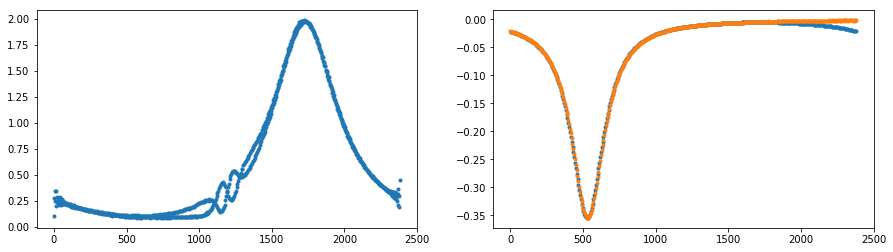

In [33]:
# if data were only noise
# data = TimeSeries(np.random.normal(0, 1, len(times)), times=times)

# first define the transform instances
fft = FFT(times, beta=2) # FFT transformer, beta is a factor on the number of interpolated points (beta * N)
sgd = Regression(reg=reg,freq=freqs)  # it use a regressor and a frequency grid, we choose same as fft


# get the fourier transforms
htilde_fft = template.to_frequencyseries(fft)
stilde_fft = data.to_frequencyseries(fft)

# get the psd, we interpolate data and use mlab.psd the interpolate frequencies
interp_data = np.interp(fft.reg_times, fft.times, data)
psd, freqs = mlab.psd(interp_data)
psd = np.interp(np.abs(fft.get_frequency(N=len(times))), freqs, psd)
psd = FrequencySeries(psd, frequency_grid=FrequencySamples(fft.get_frequency(N=len(times))), 
                      epoch=data.epoch)
uniform = True
snr = mfilter(times, stilde_fft, htilde_fft, fft, psd=psd, uniform=uniform)

if uniform:
    time_plot = fft.reg_times
else:
    time_plot = times

time_match_fft = time_plot[np.argmax(np.abs(snr))]
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot(time_plot, np.abs(snr), '.')

ax2.plot((times + time_match_fft) % max(times), template, '.')
ax2.plot(times, data, '.')
print("found match at offset {}, and theoritical was {}".format(time_match_fft, teoretical_time))

## Match filter with Regression using SGD
our developed method

0.0024154589371980675 0.0024154589371980675
found match at offset 791.6386307134213, and theoritical was 1939.4023269999961


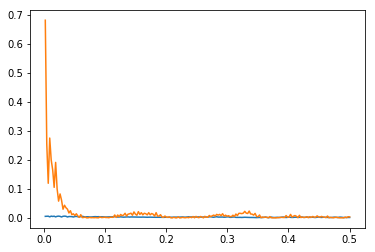

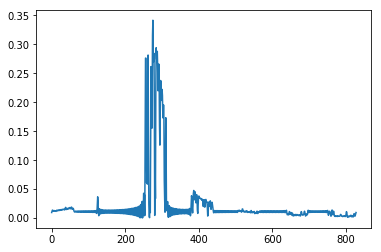

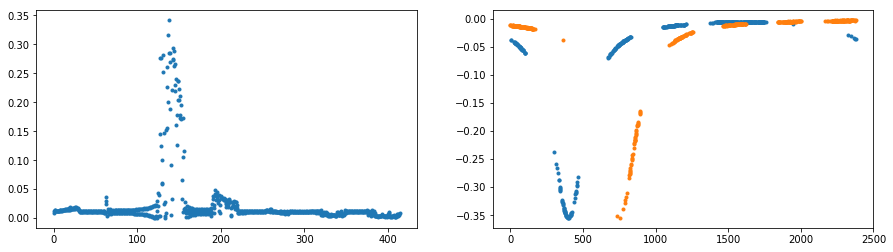

In [31]:
# we need to use normed times
n_times = TimesSamples(times * times.average_fs)
n_data = TimeSeries(data.value, times=n_times)
n_template = TimeSeries(template.value, times=n_times)
freqs = np.fft.fftfreq(N)[1:-1] # freq without 0
freqs = FrequencySamples(initial_array=freqs * )  # same freq for both methods

#ge the transforms
sgd = Regression(reg=reg,freq=freqs)
htilde_sgd = n_template.to_frequencyseries(sgd)
stilde_sgd = n_data.to_frequencyseries(sgd)

# calculate PSD using lomb-welch
psd = freqs.lomb_welch(n_times, n_data, len(n_data)//32, 0.5, norm='psd', weighted=True)
psd_true = freqs.lomb_scargle(n_times, n_data, norm='psd')
print(htilde_sgd.delta_f, psd.delta_f)
plt.figure()
plt.plot(freqs, psd)
plt.plot(freqs, psd_true)

uniform = True
# snr = mfilter(n_times, stilde_sgd, htilde_sgd, sgd, psd=psd, uniform=uniform)
prod = stilde_sgd * htilde_sgd.conj() / psd
sigma = np.sqrt((htilde_sgd * htilde_sgd.conj() / psd).sum())
snr_ft = prod / sigma
snr_ft = FrequencySeries(prod / sigma, frequency_grid=freqs, epoch=htilde_sgd.epoch)
reg_time = fft.reg_times
fs = len(reg_time) / (np.max(reg_time) - np.min(reg_time))
reg_time = TimesSamples(reg_time * times.average_fs)
reg.reset()
reg.create_dict(reg_time, freqs)
reg.set_coef(snr_ft)
snr = reg.predict()
plt.figure()
plt.plot(np.abs(snr))

if uniform:
    time_plot = reg_time
else:
    time_plot = times

time_match_sgd = time_plot[np.argmax(np.abs(snr))] / times.average_fs
print("found match at offset {}, and theoritical was {}".format(time_match_sgd, teoretical_time))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot(time_plot, np.abs(snr), '.')

ax2.plot((times - time_match_sgd) % max(times), template, '.')
ax2.plot(times, data, '.')